In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 33.4 MB/s eta 0:00:00


In [5]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.8 MB/s eta 0:00:00


In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, LineString
import rasterio
from rasterio.transform import rowcol
from rasterio.transform import from_origin

# 1. Load your original CSV
original_df = pd.read_csv("/content/drive/MyDrive/Computational intelligence/Birmingham.csv")

# 2. Convert to GeoDataFrame
original_df['geometry'] = original_df['wkt'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(original_df, geometry='geometry', crs="EPSG:27700")

# 3. Calculate lengths
gdf['length_m'] = gdf['geometry'].length

# 4. Extract all points at once
all_points = []
indices = []
for idx, geom in enumerate(gdf['geometry']):
    coords = geom.coords
    all_points.extend([Point(coords[0]), Point(coords[-1])])
    indices.extend([(idx, 'start'), (idx, 'end')])

# Create a GeoSeries of all points
points_gseries = gpd.GeoSeries(all_points, crs=gdf.crs)

# 5. Process elevations in bulk
with rasterio.open("/content/drive/MyDrive/Computational intelligence/Birminghamoutput_SRTMGL1.tif") as dem:
    # Transform all points to DEM CRS if needed
    if gdf.crs != dem.crs:
        points_gseries = points_gseries.to_crs(dem.crs)

    # Get coordinates for all points
    coords = [(p.x, p.y) for p in points_gseries]

    # Get all rows and cols at once
    rows, cols = rowcol(dem.transform, [x for x, y in coords], [y for x, y in coords])
    rows = np.array(rows)
    cols = np.array(cols)

    # Clip to DEM bounds
    mask = (rows >= 0) & (rows < dem.height) & (cols >= 0) & (cols < dem.width)

    # Read all valid elevations at once
    elevations = np.full(len(rows), np.nan)
    if mask.any():
        elevations[mask] = dem.read(1)[rows[mask], cols[mask]]

# 6. Assign elevations back to the DataFrame
elev_dict = {}
for (idx, pos), elev in zip(indices, elevations):
    if pos == 'start':
        elev_dict.setdefault(idx, {})['start_elev'] = elev
    else:
        elev_dict.setdefault(idx, {})['end_elev'] = elev

# Convert to DataFrame and merge
elev_df = pd.DataFrame.from_dict(elev_dict, orient='index')
gdf = gdf.join(elev_df)

# 7. Calculate gradients
gdf['gradient_pct'] = ((gdf['end_elev'] - gdf['start_elev']) / gdf['length_m']) * 100

# 8. Add absolute gradient and classification
gdf['abs_gradient'] = gdf['gradient_pct'].abs()
bins = [0, 3, 5, 8, 10, 15, 20, np.inf]
labels = ['0-3%', '3-5%', '5-8%', '8-10%', '10-15%', '15-20%', '>20%']
gdf['gradient_class'] = pd.cut(gdf['abs_gradient'], bins=bins, labels=labels)

# 9. Save to new CSV
output_df = gdf.drop(columns=['geometry'])
output_df.to_csv('Cambridge_with_gradients.csv', index=False)

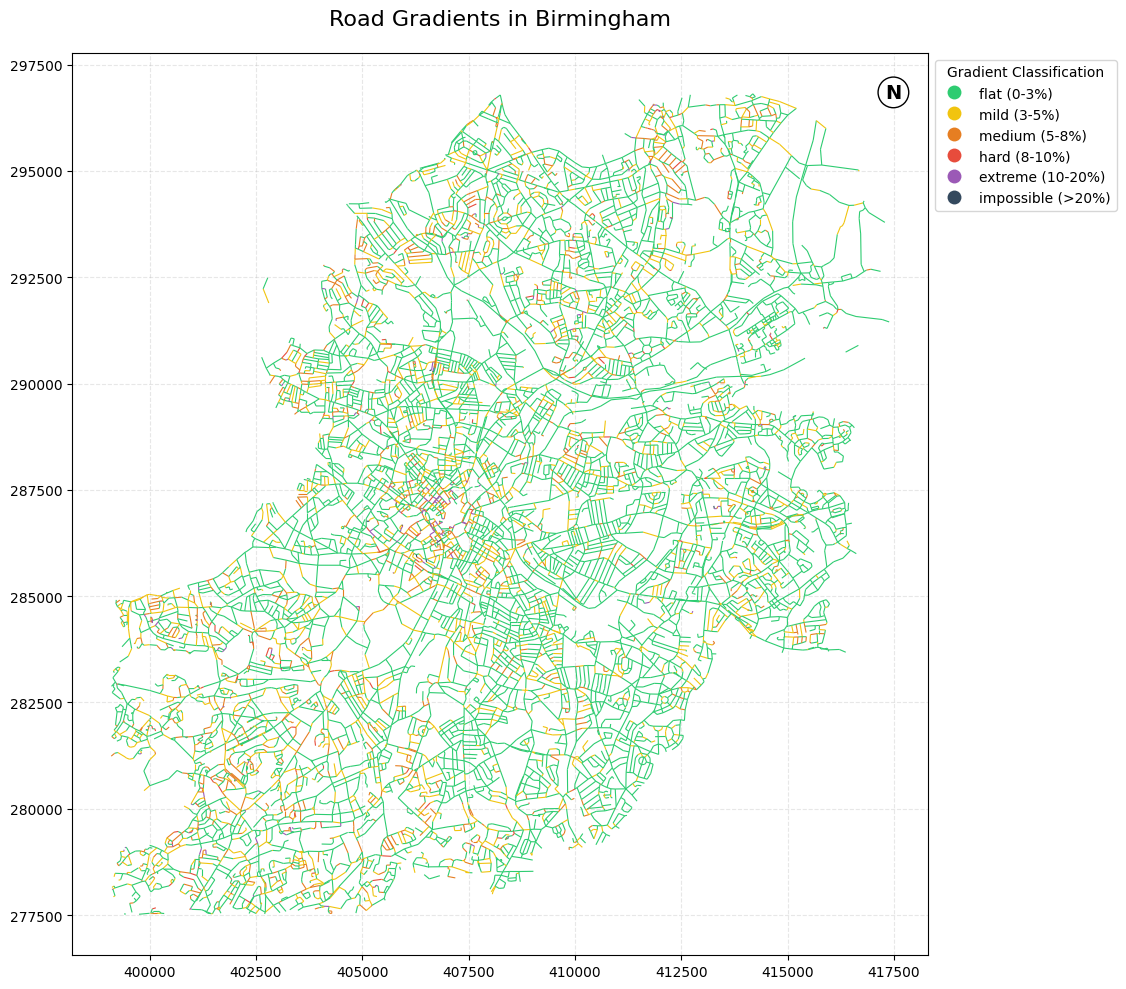

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_gradients(gdf):
    """
    Plot road network colored by gradient with custom classification.
    """
    # Create figure with adjusted size
    fig, ax = plt.subplots(figsize=(14, 10))

    # Define the new classification system
    bins = [0, 3, 5, 8, 10, 20, np.inf]
    labels = ['flat (0-3%)', 'mild (3-5%)', 'medium (5-8%)',
              'hard (8-10%)', 'extreme (10-20%)', 'impossible (>20%)']

    # Apply the new classification
    gdf['gradient_class'] = pd.cut(gdf['abs_gradient'], bins=bins, labels=labels, right=False)

    # Create a custom color map that matches the classification
    colors = ['#2ecc71', '#f1c40f', '#e67e22',
              '#e74c3c', '#9b59b6', '#34495e']
    cmap = ListedColormap(colors)

    # Plot with the new classification
    plot = gdf.plot(column='gradient_class', ax=ax,
                   cmap=cmap,
                   categorical=True,
                   legend=True,
                   legend_kwds={
                       'title': "Gradient Classification",
                       'loc': 'upper left',
                       'bbox_to_anchor': (1, 1)
                   },
                   linewidth=0.8)

    # Add title and adjust layout
    plt.title("Road Gradients in Birmingham", fontsize=16, pad=20)

    # Add grid and north arrow
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.text(0.95, 0.95, 'N', transform=ax.transAxes,
            fontsize=14, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

    plt.tight_layout()
    plt.show()

plot_gradients(gdf)